In [48]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters

from models.activ_func import *
from models.Nets import *
from models.test import test_img
from models.Update import *


from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

import torchvision

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 4  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 1 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

#         images.resize_(images.shape[0], 3*32*32)

        images = images.cuda()
        labels = labels.cuda()

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

# 1. Train LeNet with uncoded Dataset

In [28]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N_epochs = 50

net_glob = CNNCifar(args=args)
net_glob.cuda()

acc_test_FedAvg = np.empty(N_epochs)
loss_test_FedAvg = np.empty(N_epochs)

for iter in range(N_epochs):
    w_locals, loss_locals = [], []

    m = args.num_users
    
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
        
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
#     loss_train.append(loss_avg)
    
    acc_test_FedAvg[iter] = acc_test
    loss_test_FedAvg[iter] = loss_test


Test set: Average loss: 1.9165 
Accuracy: 3086/10000 (30.86%)

Round   0, Average loss 2.052

Test set: Average loss: 1.7166 
Accuracy: 3844/10000 (38.44%)

Round   1, Average loss 1.866

Test set: Average loss: 1.6110 
Accuracy: 4128/10000 (41.28%)

Round   2, Average loss 1.749

Test set: Average loss: 1.5467 
Accuracy: 4440/10000 (44.40%)

Round   3, Average loss 1.687

Test set: Average loss: 1.4918 
Accuracy: 4617/10000 (46.17%)

Round   4, Average loss 1.633

Test set: Average loss: 1.4462 
Accuracy: 4749/10000 (47.49%)

Round   5, Average loss 1.590

Test set: Average loss: 1.4069 
Accuracy: 4902/10000 (49.02%)

Round   6, Average loss 1.555

Test set: Average loss: 1.3776 
Accuracy: 5043/10000 (50.43%)

Round   7, Average loss 1.525

Test set: Average loss: 1.3544 
Accuracy: 5160/10000 (51.60%)

Round   8, Average loss 1.495

Test set: Average loss: 1.3273 
Accuracy: 5259/10000 (52.59%)

Round   9, Average loss 1.472

Test set: Average loss: 1.3180 
Accuracy: 5321/10000 (53.21

# 2. BACC without grouping, K=4

# 2.1. K=2

In [66]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 2  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 5 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [67]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)


In [57]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]
B_array = [0.5]

N_trials = 1
N_epochs = 100

lr_array = [0.001] # 0.001 is the bset

sigma_array = [0.5,1,1.5]
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]


loss_test_arr_K4_G1_v2 = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K4_G1_v2  = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))

N = 2
for sigma_idx in range(len(sigma_array)):
    
    sigma = sigma_array[sigma_idx]
    
    print('\n\n')
    print('sigma =',sigma)
    print('\n\n')
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        z_array = np.array([-0.81, 0.81])
        
        print('z_array:',z_array)
        if sigma != 0:
            for j in range(len(z_array)):
                print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))

        
        _Noise_label = np.ones((25000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1_v2[sigma_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1_v2[sigma_idx][lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)




sigma = 0.5



Learning Rate = 0.001



z_array: [-0.81  0.81]
0.8455629617601813
0.8455629617601821
@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

(T, sigma)= 3 0.5 )  0 -th Trial!!
selected users: [0 1]
conv1.weight 0.004366987546284993
conv1.bias 0.0055085718631744385
conv2.weight 0.0022214933236440024
conv2.bias 0.00238136388361454
fc1.weight 0.0008314328193664551
fc1.bias 0.0008386549229423205
fc2.weight 0.0027809090084499784
fc2.bias 0.002993911149955931
fc3.weight 0.004093751169386364
fc3.bias 0.003163816034793854

Test set: Average loss: 2.0214 
Accuracy: 3013/10000 (30.13%)

Round   0, Average loss 2.021 Test accuracy 30.130
selected users: [0 1]
conv1.weight 0.002171035607655843
conv1.bias 0.0038141335050264993
conv2.weight 0.0008994497855504354
conv2.bias 0.0015949492808431387
fc1.weight 0.00017204397916793822
fc1.bias 0.000586057702700297
fc2.weight 0.0002595631376145378
fc2.bias 0.001172883879570734
fc3.weight 0.0009284389870507377
fc3.bias 0.


Test set: Average loss: 1.7339 
Accuracy: 3834/10000 (38.34%)

Round  17, Average loss 1.734 Test accuracy 38.340
selected users: [0 1]
conv1.weight 0.0019563819302452936
conv1.bias 0.0022291202719012895
conv2.weight 0.0013531843821207683
conv2.bias 0.00409004045650363
fc1.weight 0.0005512899955113729
fc1.bias 0.002546579639116923
fc2.weight 0.0012165427207946778
fc2.bias 0.00404514620701472
fc3.weight 0.0027579852512904578
fc3.bias 0.0009629731066524982

Test set: Average loss: 1.7308 
Accuracy: 3840/10000 (38.40%)

Round  18, Average loss 1.731 Test accuracy 38.400
selected users: [0 1]
conv1.weight 0.0019772879282633463
conv1.bias 0.0021917585593958697
conv2.weight 0.0013523183266321817
conv2.bias 0.0040431939996778965
fc1.weight 0.0005551058053970336
fc1.bias 0.0025339700281620027
fc2.weight 0.001222804898307437
fc2.bias 0.004040524008728209
fc3.weight 0.002768877006712414
fc3.bias 0.000952504575252533

Test set: Average loss: 1.7356 
Accuracy: 3828/10000 (38.28%)

Round  19, Aver


Test set: Average loss: 1.7059 
Accuracy: 3912/10000 (39.12%)

Round  35, Average loss 1.706 Test accuracy 39.120
selected users: [0 1]
conv1.weight 0.0020510254965888128
conv1.bias 0.002177413087338209
conv2.weight 0.00137042502562205
conv2.bias 0.003957522101700306
fc1.weight 0.0005705748001734415
fc1.bias 0.002366486191749573
fc2.weight 0.0012594682829720632
fc2.bias 0.003924635904175895
fc3.weight 0.0029270586513337636
fc3.bias 0.0008876624517142773

Test set: Average loss: 1.7109 
Accuracy: 3902/10000 (39.02%)

Round  36, Average loss 1.711 Test accuracy 39.020
selected users: [0 1]
conv1.weight 0.0020521638128492567
conv1.bias 0.002205974111954371
conv2.weight 0.0013747690121332804
conv2.bias 0.004045363515615463
fc1.weight 0.0005721688667933146
fc1.bias 0.0023689185579617816
fc2.weight 0.0012641146069481259
fc2.bias 0.003909517256986527
fc3.weight 0.00292369354338873
fc3.bias 0.0008919654414057731

Test set: Average loss: 1.7154 
Accuracy: 3892/10000 (38.92%)

Round  37, Averag


Test set: Average loss: 1.7081 
Accuracy: 3889/10000 (38.89%)

Round  53, Average loss 1.708 Test accuracy 38.890
selected users: [0 1]
conv1.weight 0.0020929645167456733
conv1.bias 0.0023919129744172096
conv2.weight 0.0014375823736190797
conv2.bias 0.003740691114217043
fc1.weight 0.0005825003782908122
fc1.bias 0.0022688493132591247
fc2.weight 0.0012722070254976786
fc2.bias 0.0037682829868225824
fc3.weight 0.0029299350011916386
fc3.bias 0.0008932134136557579

Test set: Average loss: 1.7062 
Accuracy: 3887/10000 (38.87%)

Round  54, Average loss 1.706 Test accuracy 38.870
selected users: [0 1]
conv1.weight 0.002100014289220174
conv1.bias 0.0024458440020680428
conv2.weight 0.001437098781267802
conv2.bias 0.003685747506096959
fc1.weight 0.000580927054087321
fc1.bias 0.002281726896762848
fc2.weight 0.001270983616511027
fc2.bias 0.003776544261546362
fc3.weight 0.002927487804776146
fc3.bias 0.0008818531408905983

Test set: Average loss: 1.7047 
Accuracy: 3918/10000 (39.18%)

Round  55, Aver


Test set: Average loss: 1.7131 
Accuracy: 3890/10000 (38.90%)

Round  71, Average loss 1.713 Test accuracy 38.900
selected users: [0 1]
conv1.weight 0.002133821513917711
conv1.bias 0.0023391408224900565
conv2.weight 0.0014522600173950196
conv2.bias 0.003613634966313839
fc1.weight 0.0005837910175323487
fc1.bias 0.002310140679279963
fc2.weight 0.001284454550061907
fc2.bias 0.003833309170745668
fc3.weight 0.0029410558087485175
fc3.bias 0.0008589668199419975

Test set: Average loss: 1.7083 
Accuracy: 3908/10000 (39.08%)

Round  72, Average loss 1.708 Test accuracy 39.080
selected users: [0 1]
conv1.weight 0.002131794558631049
conv1.bias 0.0023114304058253765
conv2.weight 0.0014461288849512736
conv2.bias 0.0035413396544754505
fc1.weight 0.0005818713903427124
fc1.bias 0.002320575962464015
fc2.weight 0.0012829800446828206
fc2.bias 0.003794146790390923
fc3.weight 0.002930882147380284
fc3.bias 0.0008741372264921665

Test set: Average loss: 1.7205 
Accuracy: 3850/10000 (38.50%)

Round  73, Aver


Test set: Average loss: 1.7093 
Accuracy: 3892/10000 (38.92%)

Round  89, Average loss 1.709 Test accuracy 38.920
selected users: [0 1]
conv1.weight 0.0021352238125271266
conv1.bias 0.002238313046594461
conv2.weight 0.0014557466904322307
conv2.bias 0.003504600841552019
fc1.weight 0.0005829542477925619
fc1.bias 0.002313791712125142
fc2.weight 0.0012761804792616102
fc2.bias 0.003866598719642276
fc3.weight 0.002933174655551002
fc3.bias 0.0009151562117040157

Test set: Average loss: 1.7027 
Accuracy: 3931/10000 (39.31%)

Round  90, Average loss 1.703 Test accuracy 39.310
selected users: [0 1]
conv1.weight 0.002132092581854926
conv1.bias 0.002236731660862764
conv2.weight 0.0014534964164098104
conv2.bias 0.0034685225691646338
fc1.weight 0.0005822425683339437
fc1.bias 0.0023082623879114787
fc2.weight 0.0012749350260174463
fc2.bias 0.0038638008492333548
fc3.weight 0.002918436981382824
fc3.bias 0.0009331073611974716

Test set: Average loss: 1.7045 
Accuracy: 3916/10000 (39.16%)

Round  91, Ave


Test set: Average loss: 1.7441 
Accuracy: 3711/10000 (37.11%)

Round   7, Average loss 1.744 Test accuracy 37.110
selected users: [0 1]
conv1.weight 0.0017637541559007432
conv1.bias 0.0025863153859972954
conv2.weight 0.0011454413334528605
conv2.bias 0.0024683354422450066
fc1.weight 0.0004665757417678833
fc1.bias 0.0019966435929139456
fc2.weight 0.0009258602346692767
fc2.bias 0.0037676415273121427
fc3.weight 0.0020876311120532807
fc3.bias 0.0011540954932570458

Test set: Average loss: 1.7376 
Accuracy: 3737/10000 (37.37%)

Round   8, Average loss 1.738 Test accuracy 37.370
selected users: [0 1]
conv1.weight 0.001773740980360243
conv1.bias 0.002559525271256765
conv2.weight 0.0011582829554875691
conv2.bias 0.0024569721426814795
fc1.weight 0.0004705623388290405
fc1.bias 0.0019995879381895067
fc2.weight 0.0009441008643498496
fc2.bias 0.0038206960473741803
fc3.weight 0.002150210596266247
fc3.bias 0.0011238781735301018

Test set: Average loss: 1.7353 
Accuracy: 3735/10000 (37.35%)

Round   9


Test set: Average loss: 1.7315 
Accuracy: 3769/10000 (37.69%)

Round  25, Average loss 1.732 Test accuracy 37.690
selected users: [0 1]
conv1.weight 0.0019166888131035699
conv1.bias 0.002253794732193152
conv2.weight 0.001219512422879537
conv2.bias 0.0025735606905072927
fc1.weight 0.0004964664777119955
fc1.bias 0.0018931043644746144
fc2.weight 0.001045765100963532
fc2.bias 0.003612917803582691
fc3.weight 0.002418942962374006
fc3.bias 0.0008913131430745124

Test set: Average loss: 1.7365 
Accuracy: 3758/10000 (37.58%)

Round  26, Average loss 1.737 Test accuracy 37.580
selected users: [0 1]
conv1.weight 0.0019177504380544026
conv1.bias 0.002227631707986196
conv2.weight 0.0012187038858731587
conv2.bias 0.0025613424368202686
fc1.weight 0.0004975459178288777
fc1.bias 0.0018717830379803976
fc2.weight 0.001048900399889265
fc2.bias 0.0035736699189458576
fc3.weight 0.002420111781074887
fc3.bias 0.0008939934894442558

Test set: Average loss: 1.7356 
Accuracy: 3741/10000 (37.41%)

Round  27, Ave


Test set: Average loss: 1.7303 
Accuracy: 3779/10000 (37.79%)

Round  43, Average loss 1.730 Test accuracy 37.790
selected users: [0 1]
conv1.weight 0.0019029343128204345
conv1.bias 0.002221178418646256
conv2.weight 0.0012318611145019532
conv2.bias 0.0025248622987419367
fc1.weight 0.0004973825613657633
fc1.bias 0.001911917080481847
fc2.weight 0.0010629761786687942
fc2.bias 0.0034489833882876803
fc3.weight 0.0024360009602137976
fc3.bias 0.0008572235703468323

Test set: Average loss: 1.7349 
Accuracy: 3764/10000 (37.64%)

Round  44, Average loss 1.735 Test accuracy 37.640
selected users: [0 1]
conv1.weight 0.0019000854757097033
conv1.bias 0.0022128584484259286
conv2.weight 0.001237787405649821
conv2.bias 0.0025425138883292675
fc1.weight 0.0004977990786234538
fc1.bias 0.0019080501049757003
fc2.weight 0.0010650402023678735
fc2.bias 0.003458356928257715
fc3.weight 0.0024405601478758314
fc3.bias 0.000846186000853777

Test set: Average loss: 1.7333 
Accuracy: 3770/10000 (37.70%)

Round  45, 


Test set: Average loss: 1.7383 
Accuracy: 3774/10000 (37.74%)

Round  61, Average loss 1.738 Test accuracy 37.740
selected users: [0 1]
conv1.weight 0.00188961837026808
conv1.bias 0.0022113475327690444
conv2.weight 0.0012490848700205486
conv2.bias 0.0025556471664458513
fc1.weight 0.0005013098319371542
fc1.bias 0.0018331552545229593
fc2.weight 0.0010775897237989638
fc2.bias 0.0033933775765555246
fc3.weight 0.0024763374101547967
fc3.bias 0.0008739341050386429

Test set: Average loss: 1.7401 
Accuracy: 3774/10000 (37.74%)

Round  62, Average loss 1.740 Test accuracy 37.740
selected users: [0 1]
conv1.weight 0.001879794200261434
conv1.bias 0.002302386642744144
conv2.weight 0.0012512574593226114
conv2.bias 0.0025468748062849045
fc1.weight 0.0005034472147623697
fc1.bias 0.001829693466424942
fc2.weight 0.001078873872756958
fc2.bias 0.003429016541867029
fc3.weight 0.0024773103850228447
fc3.bias 0.0008727339096367359

Test set: Average loss: 1.7412 
Accuracy: 3761/10000 (37.61%)

Round  63, Av


Test set: Average loss: 1.7453 
Accuracy: 3747/10000 (37.47%)

Round  79, Average loss 1.745 Test accuracy 37.470
selected users: [0 1]
conv1.weight 0.0018830141756269667
conv1.bias 0.00228082233419021
conv2.weight 0.0012544357776641845
conv2.bias 0.002488092752173543
fc1.weight 0.000504269520441691
fc1.bias 0.0018718916922807693
fc2.weight 0.001084188809470525
fc2.bias 0.0034002012440136503
fc3.weight 0.0024908761183420817
fc3.bias 0.0008647569455206394

Test set: Average loss: 1.7481 
Accuracy: 3735/10000 (37.35%)

Round  80, Average loss 1.748 Test accuracy 37.350
selected users: [0 1]
conv1.weight 0.001889731354183621
conv1.bias 0.0022744393597046533
conv2.weight 0.001251882016658783
conv2.bias 0.002516042673960328
fc1.weight 0.000504268765449524
fc1.bias 0.0018561482429504395
fc2.weight 0.0010870963808089968
fc2.bias 0.0033781095629646664
fc3.weight 0.00249595528557187
fc3.bias 0.0008469583466649055

Test set: Average loss: 1.7418 
Accuracy: 3765/10000 (37.65%)

Round  81, Averag


Test set: Average loss: 1.7486 
Accuracy: 3713/10000 (37.13%)

Round  97, Average loss 1.749 Test accuracy 37.130
selected users: [0 1]
conv1.weight 0.0018885873423682318
conv1.bias 0.0023551099002361298
conv2.weight 0.0012576339642206829
conv2.bias 0.0024314254987984896
fc1.weight 0.0005040867328643799
fc1.bias 0.0018664630750815073
fc2.weight 0.0010849366112360879
fc2.bias 0.0034407820729982284
fc3.weight 0.002523747512272426
fc3.bias 0.0008398231118917465

Test set: Average loss: 1.7464 
Accuracy: 3727/10000 (37.27%)

Round  98, Average loss 1.746 Test accuracy 37.270
selected users: [0 1]
conv1.weight 0.0018883309099409315
conv1.bias 0.0023556696251034737
conv2.weight 0.0012551220258076987
conv2.bias 0.002435856033116579
fc1.weight 0.000502463976542155
fc1.bias 0.0018450329701105753
fc2.weight 0.0010833583180866544
fc2.bias 0.0034251071157909577
fc3.weight 0.002528649568557739
fc3.bias 0.0008549747988581657

Test set: Average loss: 1.7444 
Accuracy: 3738/10000 (37.38%)

Round  99,


Test set: Average loss: 1.7379 
Accuracy: 3790/10000 (37.90%)

Round  15, Average loss 1.738 Test accuracy 37.900
selected users: [0 1]
conv1.weight 0.0020549302630954317
conv1.bias 0.0019278304340938728
conv2.weight 0.0010803008079528808
conv2.bias 0.0011954773217439651
fc1.weight 0.00046063204606374103
fc1.bias 0.001656473676363627
fc2.weight 0.0008969520765637595
fc2.bias 0.0035785862377711703
fc3.weight 0.002091331425167265
fc3.bias 0.0011519666761159897

Test set: Average loss: 1.7365 
Accuracy: 3802/10000 (38.02%)

Round  16, Average loss 1.737 Test accuracy 38.020
selected users: [0 1]
conv1.weight 0.002079577843348185
conv1.bias 0.001894262619316578
conv2.weight 0.0010809688766797384
conv2.bias 0.0011924391146749258
fc1.weight 0.0004604579210281372
fc1.bias 0.0016504645347595215
fc2.weight 0.0008996696699233283
fc2.bias 0.0035529381462505887
fc3.weight 0.0021004909560793923
fc3.bias 0.0011361107230186463

Test set: Average loss: 1.7396 
Accuracy: 3811/10000 (38.11%)

Round  17


Test set: Average loss: 1.7310 
Accuracy: 3837/10000 (38.37%)

Round  33, Average loss 1.731 Test accuracy 38.370
selected users: [0 1]
conv1.weight 0.002219307025273641
conv1.bias 0.001837986521422863
conv2.weight 0.0010811958710352579
conv2.bias 0.0012401589192450047
fc1.weight 0.0004654637575149536
fc1.bias 0.0016230656454960504
fc2.weight 0.0009168819775657049
fc2.bias 0.0036480912850016638
fc3.weight 0.0021937736443110875
fc3.bias 0.0011317544616758824

Test set: Average loss: 1.7276 
Accuracy: 3838/10000 (38.38%)

Round  34, Average loss 1.728 Test accuracy 38.380
selected users: [0 1]
conv1.weight 0.002227208349439833
conv1.bias 0.0018287294854720433
conv2.weight 0.0010825615127881367
conv2.bias 0.0012235069880262017
fc1.weight 0.00046705734729766843
fc1.bias 0.0016002729535102844
fc2.weight 0.0009172347802964468
fc2.bias 0.0036748849919864108
fc3.weight 0.0021978582654680525
fc3.bias 0.0011239253915846347

Test set: Average loss: 1.7330 
Accuracy: 3812/10000 (38.12%)

Round  3


Test set: Average loss: 1.7346 
Accuracy: 3822/10000 (38.22%)

Round  51, Average loss 1.735 Test accuracy 38.220
selected users: [0 1]
conv1.weight 0.0021841031975216338
conv1.bias 0.0018201310498019059
conv2.weight 0.0011062024037043253
conv2.bias 0.0012405698653310537
fc1.weight 0.0004601288636525472
fc1.bias 0.00163738081852595
fc2.weight 0.0009121942141699413
fc2.bias 0.003725943466027578
fc3.weight 0.002205135850679307
fc3.bias 0.001082715019583702

Test set: Average loss: 1.7342 
Accuracy: 3831/10000 (38.31%)

Round  52, Average loss 1.734 Test accuracy 38.310
selected users: [0 1]
conv1.weight 0.002183416287104289
conv1.bias 0.0017512341340382893
conv2.weight 0.0011097170909245809
conv2.bias 0.001228222157806158
fc1.weight 0.00045987602074941
fc1.bias 0.0016183458268642426
fc2.weight 0.0009107921804700578
fc2.bias 0.003664627316452208
fc3.weight 0.0022028048833211264
fc3.bias 0.0010859815403819085

Test set: Average loss: 1.7328 
Accuracy: 3823/10000 (38.23%)

Round  53, Avera


Test set: Average loss: 1.7314 
Accuracy: 3835/10000 (38.35%)

Round  69, Average loss 1.731 Test accuracy 38.350
selected users: [0 1]
conv1.weight 0.0021573567390441896
conv1.bias 0.001840651345749696
conv2.weight 0.0011320255200068156
conv2.bias 0.0012140597682446241
fc1.weight 0.0004608126481374105
fc1.bias 0.0016719475388526917
fc2.weight 0.0009140482970646449
fc2.bias 0.0036786173780759177
fc3.weight 0.002220997923896426
fc3.bias 0.0011420561000704764

Test set: Average loss: 1.7307 
Accuracy: 3843/10000 (38.43%)

Round  70, Average loss 1.731 Test accuracy 38.430
selected users: [0 1]
conv1.weight 0.0021614713139004177
conv1.bias 0.001848796537766854
conv2.weight 0.0011348197857538858
conv2.bias 0.0012113689444959164
fc1.weight 0.00046208691596984864
fc1.bias 0.0016626755396525065
fc2.weight 0.0009146363962264288
fc2.bias 0.003686096696626572
fc3.weight 0.002216684250604539
fc3.bias 0.0011274226941168307

Test set: Average loss: 1.7302 
Accuracy: 3823/10000 (38.23%)

Round  71,


Test set: Average loss: 1.7335 
Accuracy: 3838/10000 (38.38%)

Round  87, Average loss 1.733 Test accuracy 38.380
selected users: [0 1]
conv1.weight 0.0021007290151384144
conv1.bias 0.00184233362476031
conv2.weight 0.001125002404054006
conv2.bias 0.001264091464690864
fc1.weight 0.0004552643696467082
fc1.bias 0.0017375111579895019
fc2.weight 0.0009200255076090495
fc2.bias 0.0036619018231119427
fc3.weight 0.002221010696320307
fc3.bias 0.00117996446788311

Test set: Average loss: 1.7348 
Accuracy: 3823/10000 (38.23%)

Round  88, Average loss 1.735 Test accuracy 38.230
selected users: [0 1]
conv1.weight 0.002082831727133857
conv1.bias 0.0017902182104686897
conv2.weight 0.001126806338628133
conv2.bias 0.0012801217380911112
fc1.weight 0.00045518426100413006
fc1.bias 0.0017206095159053802
fc2.weight 0.0009176791660369389
fc2.bias 0.003682582860901242
fc3.weight 0.002221158572605678
fc3.bias 0.0011801021173596382

Test set: Average loss: 1.7355 
Accuracy: 3827/10000 (38.27%)

Round  89, Avera

In [70]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]
B_array = [0.5]

N_trials = 1
N_epochs = 50



loss_test_arr_K2_G1_T0 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K2_G1_T0  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        i_array = np.array(range(N))
#         z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
        z_array = alpha_array - 0.05
        
        print('z_array:',z_array)
#         for j in range(len(z_array)):
#             print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
#                 coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K2_G1_T0[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K2_G1_T0[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [ 0.65710678 -0.75710678]
@BACC_Enc: N,K,T, m_i= 2 2 0 25000 

@BACC_Enc: N,K,T, m_i= 2 2 0 25000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 1.5493 
Accuracy: 4610/10000 (46.10%)

Round   0, Average loss 1.549 Test accuracy 46.100
selected users: [0 1]

Test set: Average loss: 1.2163 
Accuracy: 5754/10000 (57.54%)

Round   1, Average loss 1.216 Test accuracy 57.540
selected users: [0 1]

Test set: Average loss: 2.5787 
Accuracy: 2595/10000 (25.95%)

Round   2, Average loss 2.579 Test accuracy 25.950
selected users: [0 1]

Test set: Average loss: 14.9973 
Accuracy: 2696/10000 (26.96%)

Round   3, Average loss 14.997 Test accuracy 26.960
selected users: [0 1]

Test set: Average loss: 19.2357 
Accuracy: 2234/10000 (22.34%)

Round   4, Average loss 19.236 Test accuracy 22.340
selected users: [0 1]

Test set: Average loss: 49.7180 
Accuracy: 1844/10000 (18.44%)

Round   5, Average loss 49.718 Test accuracy 18.440
selected users: [0 1]

Test se

KeyboardInterrupt: 

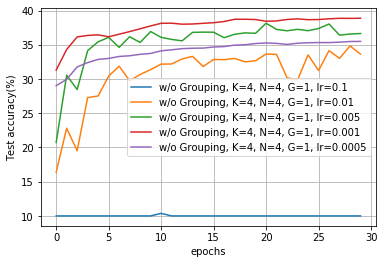

In [50]:
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]

plt.plot(acc_test_arr_K4_G1[0,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.1' )
plt.plot(acc_test_arr_K4_G1[0,1,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.01' )
plt.plot(acc_test_arr_K4_G1[0,2,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.005' )
plt.plot(acc_test_arr_K4_G1[0,3,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.001' )
plt.plot(acc_test_arr_K4_G1[0,4,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.0005' )


# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

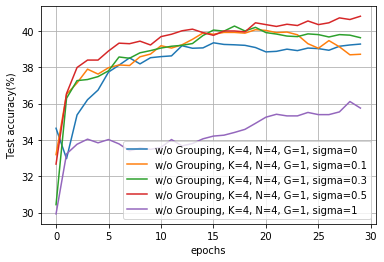

In [56]:
plt.plot(acc_test_arr_K4_G1_v1[0,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0' )
plt.plot(acc_test_arr_K4_G1_v1[1,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0.1' )
plt.plot(acc_test_arr_K4_G1_v1[2,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0.3' )
plt.plot(acc_test_arr_K4_G1_v1[3,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0.5' )
plt.plot(acc_test_arr_K4_G1_v1[4,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=1' )


# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

## 2.2. K=4

In [62]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 4  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 5 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [63]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)


In [40]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 5
sigma = 1
Noise_Alloc = [0,2,4,6,8]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [4]
B_array = [0.5]

N_trials = 1
N_epochs = 50



loss_test_arr_K4_G1 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K4_G1  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        z_array = np.array([-0.94, -0.125, 0.125, 0.94])
        
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [-0.94  -0.125  0.125  0.94 ]
0.4486236179368535
0.4857187736123886
0.48571877361238697
0.4486236179368556
@BACC_Enc: N,K,T, m_i= 4 4 5 12500 

@BACC_Enc: N,K,T, m_i= 4 4 5 12500 

(T, sigma)= 5 1 )  0 -th Trial!!
selected users: [0 1 2 3]
conv1.weight 0.0046825546688503685
conv1.bias 0.0057450756430625916
conv2.weight 0.00221137801806132
conv2.bias 0.001973040634766221
fc1.weight 0.0008330729007720947
fc1.bias 0.0008774697780609131
fc2.weight 0.002807859768943181
fc2.bias 0.002543147121156965
fc3.weight 0.00389044341586885
fc3.bias 0.002784029766917229

Test set: Average loss: 2.1409 
Accuracy: 2177/10000 (21.77%)

Round   0, Average loss 2.141 Test accuracy 21.770
selected users: [0 1 2 3]
conv1.weight 0.0012689701716105143
conv1.bias 0.0008203949158390363
conv2.weight 0.000493132472038269
conv2.bias 0.0007007064996287227
fc1.weight 8.147788047790527e-05
fc1.bias 0.00018834128665427366
fc2.weight 0.0001605666464283353
fc2.bias 0.0005881305606592269
fc3.weight 0.0006703578290


Test set: Average loss: 1.8751 
Accuracy: 3224/10000 (32.24%)

Round  17, Average loss 1.875 Test accuracy 32.240
selected users: [0 1 2 3]
conv1.weight 0.0007295861509111193
conv1.bias 0.0009937184707572062
conv2.weight 0.0005137790739536285
conv2.bias 0.0010149362497031689
fc1.weight 0.00024565706650416056
fc1.bias 0.0007606702546278636
fc2.weight 0.0005244418269111996
fc2.bias 0.0012977466519389833
fc3.weight 0.0007799324535188221
fc3.bias 0.0003959155175834894

Test set: Average loss: 1.8764 
Accuracy: 3212/10000 (32.12%)

Round  18, Average loss 1.876 Test accuracy 32.120
selected users: [0 1 2 3]
conv1.weight 0.0007364657190110949
conv1.bias 0.0009905201538155477
conv2.weight 0.0005136850972970327
conv2.bias 0.0010153441689908504
fc1.weight 0.0002480927308400472
fc1.bias 0.000774102658033371
fc2.weight 0.0005308111981740073
fc2.bias 0.001293356486019634
fc3.weight 0.0007811974201883589
fc3.bias 0.0003954425919800997

Test set: Average loss: 1.8773 
Accuracy: 3191/10000 (31.91%)



Test set: Average loss: 1.8732 
Accuracy: 3256/10000 (32.56%)

Round  35, Average loss 1.873 Test accuracy 32.560
selected users: [0 1 2 3]
conv1.weight 0.0007622079054514567
conv1.bias 0.0009548254311084747
conv2.weight 0.0005302322407563527
conv2.bias 0.000896253390237689
fc1.weight 0.0002558035850524902
fc1.bias 0.0008439296235640844
fc2.weight 0.0005269993392248003
fc2.bias 0.0013279451855591365
fc3.weight 0.0007866613212085906
fc3.bias 0.00038237974513322115

Test set: Average loss: 1.8745 
Accuracy: 3229/10000 (32.29%)

Round  36, Average loss 1.875 Test accuracy 32.290
selected users: [0 1 2 3]
conv1.weight 0.0007633494668536716
conv1.bias 0.0009622796593854824
conv2.weight 0.0005311388770739237
conv2.bias 0.0008986147586256266
fc1.weight 0.00025518161058425904
fc1.bias 0.0008421518529454867
fc2.weight 0.0005283672185171218
fc2.bias 0.0013114006391593388
fc3.weight 0.0007876724714324588
fc3.bias 0.00038437526673078536

Test set: Average loss: 1.8738 
Accuracy: 3238/10000 (32.38

# 2.3. K=4, N=4, T=0

In [65]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [5,7,9,13]
B_array = [0.5]

N_trials = 1
N_epochs = 50



loss_test_arr_K4_G1_T0 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K4_G1_T0  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        i_array = np.array(range(N))
        z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
        
        print('z_array:',z_array)
#         for j in range(len(z_array)):
#             print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
#                 coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1_T0[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1_T0[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699]
@BACC_Enc: N,K,T, m_i= 5 4 0 12500 

@BACC_Enc: N,K,T, m_i= 5 4 0 12500 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1 2 3 4]

Test set: Average loss: 2.0013 
Accuracy: 2079/10000 (20.79%)

Round   0, Average loss 2.001 Test accuracy 20.790
selected users: [0 1 2 3 4]

Test set: Average loss: 22.4331 
Accuracy: 2126/10000 (21.26%)

Round   1, Average loss 22.433 Test accuracy 21.260
selected users: [0 1 2 3 4]

Test set: Average loss: 62.9370 
Accuracy: 1621/10000 (16.21%)

Round   2, Average loss 62.937 Test accuracy 16.210
selected users: [0 1 2 3 4]

Test set: Average loss: 142.2053 
Accuracy: 1528/10000 (15.28%)

Round   3, Average loss 142.205 Test accuracy 15.280
selected users: [0 1 2 3 4]

Test set: Average loss: 278.6917 
Accuracy: 1094/10000 (10.94%)

Round   4, Average loss 278.692 Test accuracy 10.940
selected users: [0 1 2 3 4]

Test set: Average loss: 464.2436 
Accuracy: 994/10000 (9.94%)

Rou


Test set: Average loss: 510.0565 
Accuracy: 1251/10000 (12.51%)

Round   3, Average loss 510.057 Test accuracy 12.510
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 587.4965 
Accuracy: 1110/10000 (11.10%)

Round   4, Average loss 587.496 Test accuracy 11.100
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 659.0045 
Accuracy: 1268/10000 (12.68%)

Round   5, Average loss 659.005 Test accuracy 12.680
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 735.8657 
Accuracy: 1467/10000 (14.67%)

Round   6, Average loss 735.866 Test accuracy 14.670
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 775.0035 
Accuracy: 1334/10000 (13.34%)

Round   7, Average loss 775.003 Test accuracy 13.340
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 802.8011 
Accuracy: 1260/10000 (12.60%)

Round   8, Average loss 802.801 Test accuracy 12.600
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 786.0416 
Accuracy: 1192/10000 (11.92%)

Round   9, Average loss 786.


Test set: Average loss: 13.2764 
Accuracy: 1775/10000 (17.75%)

Round   6, Average loss 13.276 Test accuracy 17.750
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 15.9428 
Accuracy: 1579/10000 (15.79%)

Round   7, Average loss 15.943 Test accuracy 15.790
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 19.9954 
Accuracy: 1795/10000 (17.95%)

Round   8, Average loss 19.995 Test accuracy 17.950
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 24.7406 
Accuracy: 1563/10000 (15.63%)

Round   9, Average loss 24.741 Test accuracy 15.630
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 19.8102 
Accuracy: 1564/10000 (15.64%)

Round  10, Average loss 19.810 Test accuracy 15.640
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 7.8099 
Accuracy: 1366/10000 (13.66%)

Round  11, Average loss 7.810 Test accuracy 13.660
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 22.3433 
Accuracy: 1245/10000 (12.45%)

Round  12, Average 


Test set: Average loss: 2.3027 
Accuracy: 1000/10000 (10.00%)

Round   8, Average loss 2.303 Test accuracy 10.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Test set: Average loss: 2.3027 
Accuracy: 1018/10000 (10.18%)

Round   9, Average loss 2.303 Test accuracy 10.180
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Test set: Average loss: 2.3027 
Accuracy: 1020/10000 (10.20%)

Round  10, Average loss 2.303 Test accuracy 10.200
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Test set: Average loss: 2.3020 
Accuracy: 1000/10000 (10.00%)

Round  11, Average loss 2.302 Test accuracy 10.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Test set: Average loss: 2.3021 
Accuracy: 1005/10000 (10.05%)

Round  12, Average loss 2.302 Test accuracy 10.050
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Test set: Average loss: 2.3025 
Accuracy: 1125/10000 (11.25%)

Round  13, Average loss 2.302 Test accuracy 11.250
selected users: [ 0  1  2